In [8]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import sys,os
sys.path.append(os.path.expanduser('~')+'work'+os.path.sep+'common_libraries')
sys.path.append('/Users/yzerlaut/work/common_libraries/')
import graphs
import graphs.my_graph as my_graph
import data_analysis.signanalysis as signanalysis
%load_ext autoreload
%autoreload 2 # enable reloading|
from IPython.display import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


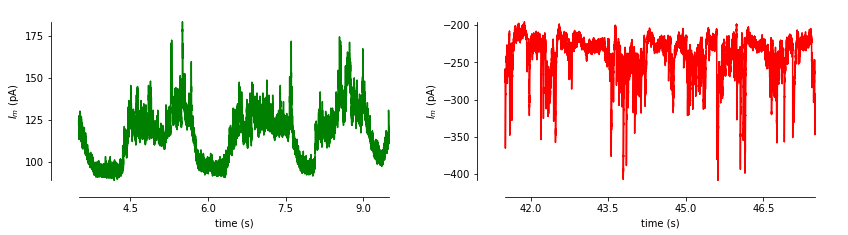

In [9]:
# Starting from the raw data ...
dt=1e-4 # 10kHz samplings 

# data taken from Cell 2 (putative SOM+ cell) on 1st Dec. 2016, recorded by Ste Zucca

exc = np.load('exc.npz') # Voltage-Clamp recording at -85mV, sample from Exps_Ste_and_Yann/2016_12_1/
inh = np.load('inh.npz') # Voltage-Clamp recording at +15mV, sample from Exps_Ste_and_Yann/2016_12_1/

# Let's have a look on the raw data, 
tsample = 6 # sample of recording time in seconds
fig, AX = plt.subplots(1, 2, figsize=(14,4));plt.subplots_adjust(bottom=.25)
# excitation
AX[0].plot(exc['t'][:int(tsample/dt)], exc['v1'][:int(tsample/dt)], 'g-')
my_graph.set_plot(AX[0], ylabel='$I_m$ (pA)', xlabel='time (s)')
# inhibition
AX[1].plot(inh['t'][:int(tsample/dt)], inh['v1'][:int(tsample/dt)], 'r-')
my_graph.set_plot(AX[1], ylabel='$I_m$ (pA)', xlabel='time (s)')
fig.savefig('figs/raw_recordings.png')

# Excitatory and Inhibitory dynamics during Up and Down states _in vivo_

## Analysis of Voltage-Clamp measurements

#### raw data :

<img src="figs/raw_recordings.png", width=900>

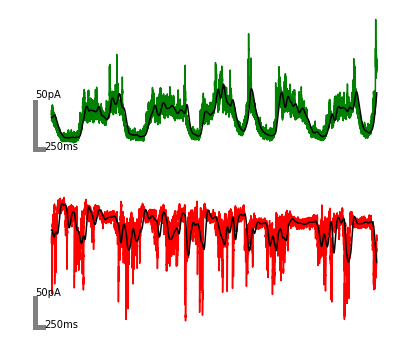

In [10]:
# we high-pass filter the signal between 0.01 Hz to remove the DC component and the slow drifts
lowcut, highcut = 5., 1e-2
Iexc = signanalysis.butter_highpass_filter(exc['v1']-exc['v1'].mean(), highcut, 1./dt, order=2)
Iinh = signanalysis.butter_highpass_filter(inh['v1']-inh['v1'].mean(), highcut, 1./dt, order=2)
# then we low-pass to identify up and down states
Iexc_LP = signanalysis.butter_lowpass_filter(Iexc, lowcut, 1./dt, order=3)
Iinh_LP = signanalysis.butter_lowpass_filter(Iinh, lowcut, 1./dt, order=3)

# Let's have a look on the data again
tsample = 10 #len(exc['t'])*dt # sample of recording time in seconds
fig, AX = plt.subplots(2, figsize=(7,6))
# excitation
my_graph.plot_with_bars_only(AX[0], 1e3*exc['t'][:int(tsample/dt)], Iexc[:int(tsample/dt)],\
                             xscale=250, yscale=50, xunit='ms', yunit='pA', color='g')
AX[0].plot(1e3*exc['t'][:int(tsample/dt)], Iexc_LP[:int(tsample/dt)], 'k-')

# inhibition
my_graph.plot_with_bars_only(AX[1], 1e3*inh['t'][:int(tsample/dt)], Iinh[:int(tsample/dt)],\
                             xscale=250, yscale=50, xunit='ms', yunit='pA', color='r')
AX[1].plot(1e3*inh['t'][:int(tsample/dt)], Iinh_LP[:int(tsample/dt)], 'k-')

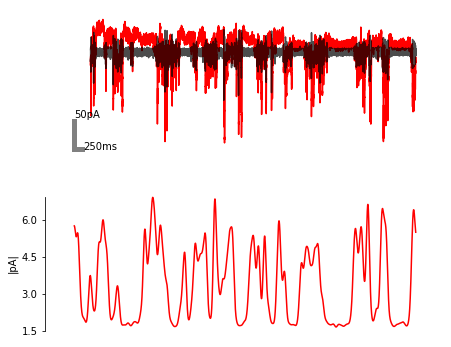

In [11]:
# for the inhibition, this will not make it, so different strategy, we rely on the high frequency content
Iinh_HP = signanalysis.butter_highpass_filter(Iinh, 100., 1./dt, order=2) # high pass at 100Hz cutoff
Iinh_LP2 = signanalysis.gaussian_smoothing(np.abs(Iinh_HP), int(40e-3/dt))

fig, [ax,ax2] = plt.subplots(2, figsize=(7,6))
my_graph.plot_with_bars_only(ax, 1e3*inh['t'][:int(tsample/dt)], Iinh[:int(tsample/dt)],\
                             xscale=250, yscale=50, xunit='ms', yunit='pA', color='r')
ax.plot(1e3*inh['t'][:int(tsample/dt)], Iinh_HP[:int(tsample/dt)], 'k-', alpha=.7)

ax2.plot(1e3*inh['t'][:int(tsample/dt)], Iinh_LP2[:int(tsample/dt)], color='r')
my_graph.set_plot(ax2, 'left', xticks=[], ylabel='|pA|')

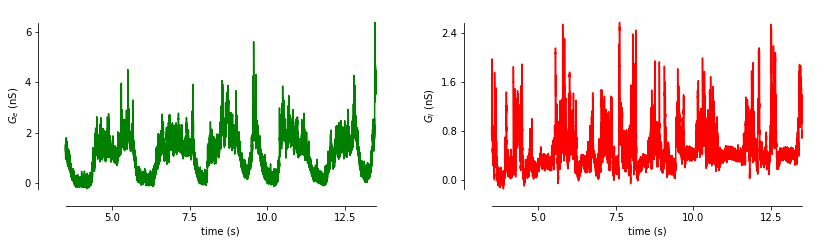

In [17]:
# the minimum of the low pass filtered provides the "0-current baseline"

# this will allow the transformation to conductances, given the holding potentials
holding_potential_for_inh = 80.
holding_potential_for_exc= -20.

Gexc = -(Iexc-Iexc_LP.min())/holding_potential_for_exc
Gexc_LP = -(Iexc_LP-Iexc_LP.min())/holding_potential_for_exc
Ginh = -(Iinh-Iinh_LP.max())/holding_potential_for_inh
Ginh_LP = -(Iinh_LP-Iinh_LP.max())/holding_potential_for_inh

tsample = 10 #len(exc['t'])*dt # sample of recording time in seconds
fig, AX = plt.subplots(1, 2, figsize=(14,3.5))
# excitation
AX[0].plot(exc['t'][:int(tsample/dt)], Gexc[:int(tsample/dt)], color='g')
my_graph.set_plot(AX[0], ylabel='$G_e$ (nS)', xlabel='time (s)')
# inhibition
AX[1].plot(exc['t'][:int(tsample/dt)], Ginh[:int(tsample/dt)], color='r')
my_graph.set_plot(AX[1], ylabel='$G_i$ (nS)', xlabel='time (s)')

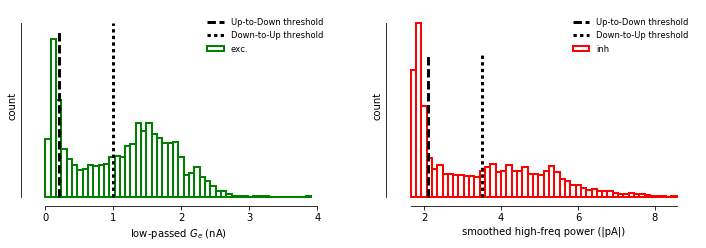

In [18]:
# thresholds for up and down states detections
UD_tvfa_exc_threshold = 0.2
DU_tvfa_exc_threshold = 1.
UD_tvfa_inh_threshold = 2.1
DU_tvfa_inh_threshold = 3.5

# histogram of time varying fluctuations

fig, AX = plt.subplots(1,2,figsize=(12,3.5))

AX[0].hist(Gexc_LP, bins=50, color='b', label='exc.', facecolor='w', edgecolor='g', lw=2)
AX[0].plot([UD_tvfa_exc_threshold,UD_tvfa_exc_threshold], [0, AX[0].get_ylim()[1]], 'k--', lw=3, label='Up-to-Down threshold')
AX[0].plot([DU_tvfa_exc_threshold,DU_tvfa_exc_threshold], [0, AX[0].get_ylim()[1]], 'k:', lw=3, label='Down-to-Up threshold')
my_graph.set_plot(AX[0], xlabel='low-passed $G_e$ (nA)', ylabel='count', yticks=[])

AX[1].hist(Iinh_LP2, bins=50, label='inh', facecolor='w', edgecolor='r', lw=2)
AX[1].plot([UD_tvfa_inh_threshold,UD_tvfa_inh_threshold], [0, AX[0].get_ylim()[1]], 'k--', lw=3, label='Up-to-Down threshold')
AX[1].plot([DU_tvfa_inh_threshold,DU_tvfa_inh_threshold], [0, AX[0].get_ylim()[1]], 'k:', lw=3, label='Down-to-Up threshold')
my_graph.set_plot(AX[1], xlabel='smoothed high-freq power (|pA|)', ylabel='count', yticks=[])

for ax in AX: ax.legend(frameon=False, prop={'size':'small'})
    

In [19]:
# functions for identifying up and down states
    
def get_time_varying_fluct_amplitude(signal, idt_sbsmpl=int(50e-3/dt)):
    """
    computes the time-varying fluctuation amplitude
    the fluctuations are evaluated over a window of size *idt_sbsmpl* (i.e. in index values)
    """
    tvfa = 0.*signal # time varying fluctuation amplitude
    for i in range(len(signal)):
        tvfa[i] = np.std(signal[np.max([0,i-idt_sbsmpl]):np.min([len(signal)-1,i+idt_sbsmpl])])
    return tvfa

def get_up_and_down_states_intervals(signal, UD_threshold, DU_threshold,):
    """
    Up states are defined as periods of strong fluctuations, Down states -> low fluctuations
    we return the signal samples of Up state and the signal samples of Down state
    """
    i_down, i_up, Signals_samples_up, Signals_samples_down = [], [], [], []
    i_up_start, i_down_end, i_down_start, i_up_end = 0, 0, 0, 0
    up_flag = True
    if signal[0]<=DU_threshold: up_flag=False
    for i in range(1,len(signal)):
        if (signal[i]>DU_threshold) and (signal[i-1]<=DU_threshold) and not up_flag:
            # fluctuation increase -> Down-to-Up transition
            i_up_start, i_down_end = i-int(1/(lowcut*dt)), i
            i_down.append([i_down_start,i_down_end])
            up_flag = True
        if (signal[i]<UD_threshold) and (signal[i-1]>=UD_threshold) and up_flag:
            # fluctuation decrease -> Up-to-Down transition
            i_down_start, i_up_end = i-int(1/(lowcut*dt)), i
            i_up.append([i_up_start,i_up_end])
            up_flag = False
    return i_up, i_down

In [10]:
# computing the Up and Down states samples based on the fluctuations criteria...

# --> excitatory currents
Exc_i_up, Exc_i_down = get_up_and_down_states_intervals(Gexc_LP, UD_tvfa_exc_threshold, DU_tvfa_exc_threshold)
# --> inhibitory currents
Inh_i_up, Inh_i_down = get_up_and_down_states_intervals(Iinh_LP2, UD_tvfa_inh_threshold, DU_tvfa_inh_threshold)

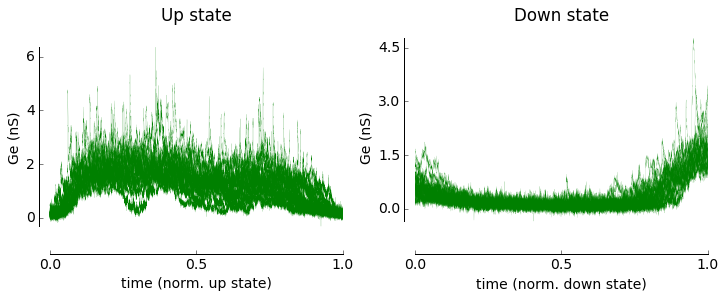

In [11]:
# Excitatory currents

fig, AX = plt.subplots(1, 2, figsize=(12,4))
# Up state
AX[0].set_title('Up state')
for (i0,i1) in Exc_i_up[1:-1]:
    AX[0].plot(np.linspace(0,1,i1-i0), Gexc[i0:i1], 'g', lw=.1)
my_graph.set_plot(AX[0], xlabel='time (norm. up state)', ylabel='Ge (nS)', xticks=[0,0.5,1.])
# Down state
AX[1].set_title('Down state')
for (i0,i1) in Exc_i_down[1:-1]:
    AX[1].plot(np.linspace(0,1,i1-i0), Gexc[i0:i1], 'g', lw=.1)
my_graph.set_plot(AX[1], xlabel='time (norm. down state)', ylabel='Ge (nS)', xticks=[0,0.5,1.])

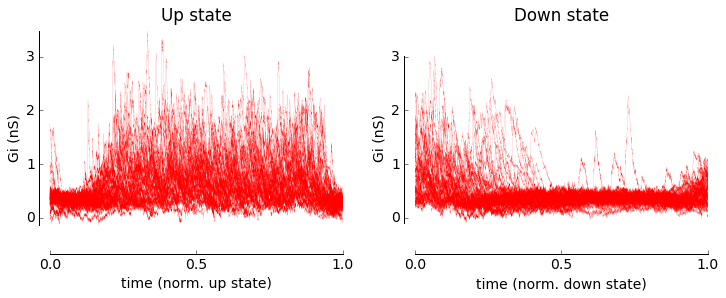

In [12]:
# Inhibitory currents

fig, AX = plt.subplots(1, 2, figsize=(12,4))
# Up state
AX[0].set_title('Up state')
for (i0,i1) in Inh_i_up[1:-1]:
    AX[0].plot(np.linspace(0,1,i1-i0), Ginh[i0:i1], 'r', lw=.1)
my_graph.set_plot(AX[0], xlabel='time (norm. up state)', ylabel='Gi (nS)', xticks=[0,0.5,1.])
# Down state
AX[1].set_title('Down state')
for (i0,i1) in Inh_i_down[1:-1]:
    AX[1].plot(np.linspace(0,1,i1-i0), Ginh[i0:i1], 'r', lw=.1)
my_graph.set_plot(AX[1], xlabel='time (norm. down state)', ylabel='Gi (nS)', xticks=[0,0.5,1.])

In [13]:
# Comparing the excitation and inhibition along the two state, analogous to Neske et al. J. Neurosci. 2015

discret = 100 # we need to have the same discretization for all samples to compare them
t = np.linspace(0,1,discret)

# Excitatory Currents
Gexc_up, Gexc_down = np.zeros((len(t), len(Exc_i_up[1:-1]))), np.zeros((len(t), len(Exc_i_down[1:-1])))
for j, (i0,i1) in zip(range(len(Exc_i_up[1:-1])), Exc_i_up[1:-1]):
    resampling_indexes = np.arange(discret)[np.array(np.arange(i1-i0)/(i1-i0)*discret, dtype=int)]
    Gexc_up[:,j] = [Gexc[i0:i1][resampling_indexes==k].mean() for k in range(discret)]
for j, (i0,i1) in zip(range(len(Exc_i_down[1:-1])), Exc_i_down[1:-1]):
    resampling_indexes = np.arange(discret)[np.array(np.arange(i1-i0)/(i1-i0)*discret, dtype=int)]
    Gexc_down[:,j] = [Gexc[i0:i1][resampling_indexes==k].mean() for k in range(discret)]

# Inhibitory currents
Ginh_up, Ginh_down = np.zeros((len(t), len(Inh_i_up[1:-1]))), np.zeros((len(t), len(Inh_i_down[1:-1])))
for j, (i0,i1) in zip(range(len(Inh_i_up[1:-1])), Inh_i_up[1:-1]):
    resampling_indexes = np.arange(discret)[np.array(np.arange(i1-i0)/(i1-i0)*discret, dtype=int)]
    Ginh_up[:,j] = [Ginh[i0:i1][resampling_indexes==k].mean() for k in range(discret)]
for j, (i0,i1) in zip(range(len(Inh_i_down[1:-1])), Inh_i_down[1:-1]):
    resampling_indexes = np.arange(discret)[np.array(np.arange(i1-i0)/(i1-i0)*discret, dtype=int)]
    Ginh_down[:,j] = [Ginh[i0:i1][resampling_indexes==k].mean() for k in range(discret)]

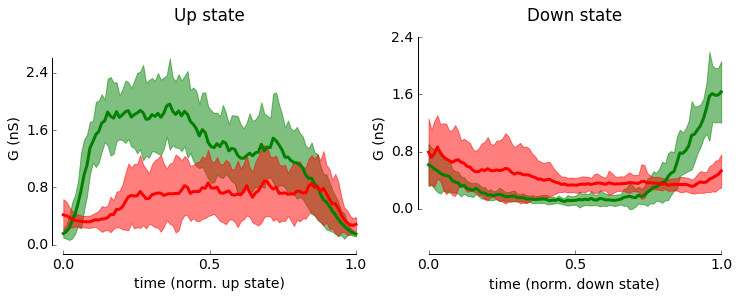

In [15]:
# plotting

fig, AX = plt.subplots(1, 2, figsize=(12,4))
# Up state
AX[0].set_title('Up state')
AX[0].plot(np.linspace(0,1,discret), Gexc_up.mean(axis=-1), 'g-', lw=3)
AX[0].fill_between(np.linspace(0,1,discret), Gexc_up.mean(axis=-1)-Gexc_up.std(axis=-1),\
           Gexc_up.mean(axis=-1)+Gexc_up.std(axis=-1), color='g', alpha=.5)
AX[0].plot(np.linspace(0,1,discret), Ginh_up.mean(axis=-1), 'r-', lw=3)
AX[0].fill_between(np.linspace(0,1,discret), Ginh_up.mean(axis=-1)-Ginh_up.std(axis=-1),\
           Ginh_up.mean(axis=-1)+Ginh_up.std(axis=-1), color='r', alpha=.5)
my_graph.set_plot(AX[0], xlabel='time (norm. up state)', ylabel='G (nS)', xticks=[0,0.5,1.])
# Down state
AX[1].set_title('Down state')
AX[1].plot(np.linspace(0,1,discret), Gexc_down.mean(axis=-1), 'g-', lw=3)
AX[1].fill_between(np.linspace(0,1,discret), Gexc_down.mean(axis=-1)-Gexc_down.std(axis=-1),\
           Gexc_down.mean(axis=-1)+Gexc_down.std(axis=-1), color='g', alpha=.5)
AX[1].plot(np.linspace(0,1,discret), Ginh_down.mean(axis=-1), 'r-', lw=3)
AX[1].fill_between(np.linspace(0,1,discret), Ginh_down.mean(axis=-1)-Ginh_down.std(axis=-1),\
           Ginh_down.mean(axis=-1)+Ginh_down.std(axis=-1), color='r', alpha=.5)
my_graph.set_plot(AX[1], xlabel='time (norm. down state)', ylabel='G (nS)', xticks=[0,0.5,1.])
fig.savefig('figs/average_conductances.png')

## For a comparison let's have a look at the _in vitro_ results of Neske 2015

<img src="figs/neske.png",width=400>

Note that the variations are variations over cycles in our case whereas it is variations over cells after computing the mean for each cell in the Neske et al. case


But something is striking from the raw traces


## **The mean-to-fluctuations ratio is very different in between excitation and inhibition !**

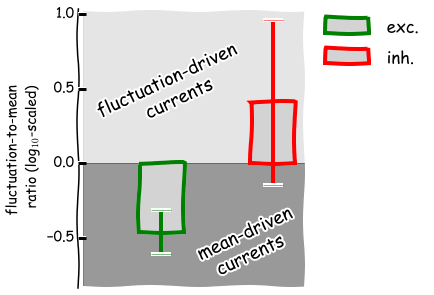

In [16]:
# means estimated on centers of identified states and with respect to down states levels
means_exc = Gexc_up[25:75,:].mean(axis=0)-Gexc_down[25:75,:].mean() 
means_inh = Ginh_up[25:75,:].mean(axis=0)-Ginh_down[25:75,:].mean()
# same for fluctuations, evaluated on center !
fluct_exc = Gexc_up[25:75,:].std(axis=0)
fluct_inh = Ginh_up[25:75,:].std(axis=0)
Ie_ratio = np.mean(fluct_exc/means_exc)
Ii_ratio = np.mean(fluct_inh/means_inh)

# simple estimate of the variability for the log plot (to be polished !)
Ie_std = np.log(Ie_ratio+np.std(fluct_exc/means_exc))/np.log(10)-np.log(Ie_ratio)/np.log(10)
Ii_std = np.log(Ii_ratio+np.std(fluct_inh/means_inh))/np.log(10)-np.log(Ii_ratio)/np.log(10)

with plt.xkcd():
    plt.rcParams.update({'font.size': 18})

    fig, ax = plt.subplots(1, figsize=(4,5))
    bar1 = my_graph.add_errorbar(ax, 0, np.log(Ie_ratio)/np.log(10),\
                          Ie_std, color='g', width=.4)
    bar2 = my_graph.add_errorbar(ax, 1, np.log(Ii_ratio)/np.log(10),\
                          Ii_std, color='r', width=.4)
    my_graph.set_plot(ax, ['left'], xticks=[], xlim=[-.5,1.5],\
                     ylabel='fluctuation-to-mean \n ratio (log$_{10}$-scaled)')
    ax.fill_between(ax.get_xlim(), [0,0], [ax.get_ylim()[1],ax.get_ylim()[1]], color='k', alpha=.1)
    text1 = ax.annotate("fluctuation-driven \n        currents", xy=(-.4, .6))
    ax.fill_between(ax.get_xlim(), [0,0], [ax.get_ylim()[0],ax.get_ylim()[0]], color='k', alpha=.4)
    text2 = ax.annotate("mean-driven \n  currents", xy=(.5, -.5))
    ax.legend([bar1, bar2], ['exc.', 'inh.'], frameon=False, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    for text in [text1, text2]: text.set_rotation(25)
    fig.savefig('figs/current_picture.png')

# Asynchronous dynamics in neocortical networks 

### Theoretical perspective

### Pioneering theoretical work  [Van Vreeswijk and Sompolinsky, Science 1996](http://science.sciencemag.org/content/274/5293/1724.long):

  Neocortical networks display a chaotic state, where, because of the excitatory/inhibitory recurrent architecture of cortical assemblies, the activity can be _**balanced**_. In this setting, the mean excitatory and inhibitory network activity settles the membrane polarization sightly below spiking threshold and single cell firing happens because of fluctuations. Illustrated on Figure 1 in the paper:
<img src="figs/vw_somp_1996.png",width=300>
  Thus, for a single cell, if its presynaptic activity exhibits irregular spiking, its output firing will also be irregular in this setting.  
  $\Rightarrow$ At the network level there exist an asynchronous dynamical state where all neurons fire irregularly (recurrent interactions promote dynamical regime where single cells exhibit self-consistent behaviors)  

But this scenario is valid only in sparsely connected networks, where neurons share a weak number of common synapses (to insure asynchronicity among neurons) and where current fluctuations remain of large amplitude (if neurons have too many synapses, the law of large numbers applies and makes the fluctuations very low with respect to their mean, what would require a fine-tuning of the depolarization level with respect to the threshold to be sensitive to fluctuations)

### Alternative theory for densely connected networks [Renart et al., Science 2010](http://science.sciencemag.org/content/327/5965/587)

Asynchronous dynamics (spontaneous activity of arbitrary low correlation between pairwise spiking) emerges as a consequence of an **active decorrelation** mechanism in balanced recurrent networks, excitatory current and inhibitory current

<img src="figs/Renart.png",width=700>

## In general other conductances measurements

#### Haider et al., J. Neurosci. 2006

<img src="figs/Haider2006.png",width=600>

## In general other conductances measurements

#### Haider et al., Nature 2013

<img src="figs/Haider2013.png",width=700>

# Questions to be answered

- How can there be a stable ongoing dynamics without balanced inhibition ?  


- How are affected the integrative properties of neural networks in the non-balanced case ? (linearization of responses to afferent inputs, fast-tracking of input temporal modulations, etc..)  


- Conductance measurements seems to give a bit a different answer in higher mammals (e.g. cat), does this picture only applies to rodent neocortex ?  



# Clues/hints for a novel dynamical regime

- Excitatory currents and inhibitory currents are qualitatively different, excitation is mean-driven, inhibition is fluctuation-driven  


- Activity is very sparse, the synaptic bombardment is not that massive... no very strong conductance changes  


- Neurons share much of the excitation and much fewer of the inhibition, so that their subthreshold $V_m$ can be correlated across neurons (Poulet & Petersen, Nature 2008) while their spiking remains irregular ()  


